# TPF stack run example

This notebook shows and example run of a TPF stack run with the API parameters used to create 
the light curves created in Martinez-Palomera et al. 2023 which are available through 
[MAST](https://archive.stsci.edu/doi/resolve/resolve.html?doi=10.17909/7jbr-w430).

In [73]:
import yaml
import fitsio
import numpy as np
import lightkurve as lk
import psfmachine as pm
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from matplotlib import cm

## 1. Load TPFs

In the paper, an specific stack of TPFs where used in order to balance the computing load while ensuring number of sources and pixels in the scene. 
File `'config/kbonus-bkg/kepler_tpf_map_q05.csv'` has the batch distributions for TPFs available during quarter 5.
For this example we will run batch number 1 of TPFs from quarter 5 channel 37 which contains 244 TPFs.

In [48]:
batch_table = pd.read_csv('../config/kbonus-bkg/kepler_tpf_map_q05.csv', index_col=0)

batch = batch_table.query("quarter == 5 and channel == 37 and batch == 8")
batch

,file_name,quarter,channel,ra,dec,col,row,batch
57328,0097/009764758/kplr009764758-2010174085026_lpd...,5,37,289.234640,46.53123,853,523,8.0
57329,0097/009703982/kplr009703982-2010174085026_lpd...,5,37,289.070610,46.44623,981,516,8.0
57330,0097/009703887/kplr009703887-2010174085026_lpd...,5,37,289.023000,46.42197,1018,515,8.0
57331,0096/009642648/kplr009642648-2010174085026_lpd...,5,37,288.955841,46.39048,1069,515,8.0
57332,0097/009703892/kplr009703892-2010174085026_lpd...,5,37,289.026090,46.42023,1018,513,8.0
...,...,...,...,...,...,...,...,...
57567,0093/009398526/kplr009398526-2010174085026_lpd...,5,37,289.406370,45.95659,1055,31,8.0
57568,0094/009459705/kplr009459705-2010174085026_lpd...,5,37,289.630850,46.06104,885,31,8.0
57569,0093/009398569/kplr009398569-2010174085026_lpd...,5,37,289.430730,45.96783,1036,31,8.0
57570,0094/009459605/kplr009459605-2010174085026_lpd...,5,37,289.578840,46.03328,926,29,8.0


We will use the information in the `batch` table to download the corresponding TPFs using `lightkurve`.
Downloading TPFs might take a few minutes depending on internet connection.

In [49]:
tpfs = []
for k, row in tqdm(batch.iterrows(), total=len(batch)):
    kic = int(row["file_name"].split("/")[1])
    tpfs.append(lk.search_targetpixelfile(f"KIC {kic}", mission="Kepler", quarter=5, cadence="long").download())
    
tpfs = lk.TargetPixelFileCollection(tpfs)

100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [07:55<00:00,  1.95s/it]


In [50]:
tpfs

TargetPixelFileCollection of 244 objects:
    0: KeplerTargetPixelFile Object (ID: 9764758)
    1: KeplerTargetPixelFile Object (ID: 9703982)
    2: KeplerTargetPixelFile Object (ID: 9703887)
    3: KeplerTargetPixelFile Object (ID: 9642648)
    4: KeplerTargetPixelFile Object (ID: 9703892)
    5: KeplerTargetPixelFile Object (ID: 9642631)
    6: KeplerTargetPixelFile Object (ID: 9703827)
    7: KeplerTargetPixelFile Object (ID: 9764797)
    8: KeplerTargetPixelFile Object (ID: 9703890)
    9: KeplerTargetPixelFile Object (ID: 9704127)
    10: KeplerTargetPixelFile Object (ID: 9704078)
    11: KeplerTargetPixelFile Object (ID: 9642683)
    12: KeplerTargetPixelFile Object (ID: 9764820)
    13: KeplerTargetPixelFile Object (ID: 9704169)
    14: KeplerTargetPixelFile Object (ID: 9704124)
    15: KeplerTargetPixelFile Object (ID: 9642778)
    16: KeplerTargetPixelFile Object (ID: 9704113)
    17: KeplerTargetPixelFile Object (ID: 9704152)
    18: KeplerTargetPixelFile Object (ID: 9642699)

##  2. Load PSFMachine parameter files

Now we load YAML files containing the parameter values used to run PSFMachine.

The YAML file contains parameters for multiple methods which are accessed as a dictionary, e.g. `config["init"]`.

In [51]:
with open("../config/kbonus-bkg/tpfmachine_keplerTPFs_config.yaml", "r") as f:
    config = yaml.safe_load(f)

print(config.keys())

dict_keys(['init', 'build_shape_model', 'compute_aperture_photometry', 'time_model', 'fit_model', 'get_source_centroids'])


## 3. Run PSFMachine 

### 3.1 Initialize

Now we initialized `psfmahcine` using the parameters in the configuration file and the TPFs

In [63]:
mac = pm.TPFMachine.from_TPFs(tpfs, **config["init"])

[autoreload of psfmachine.utils failed: Traceback (most recent call last):
  File "/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 293, in update_function
    setattr(old, name, getattr(new, name))
ValueError: get_gaia_sources() requires a code object with 0 free vars, not 5
]
<__array_function__ internals>:180: RuntimeWarning: All-NaN axis encountered
2023-06-07 20:14:30,258 - astroquery - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [64]:
mac

TPFMachine (N sources, N times, N pixels): (632, 4487, 8029)

### 3.2 Visualize the scene

Let's see a plot of the scene with TPFs and the Gaia source on it.
The API allows for sources outside the coverage of the TPFs. 
The LFD method can still fit these sources using data data from the wings, although this does not work always. 

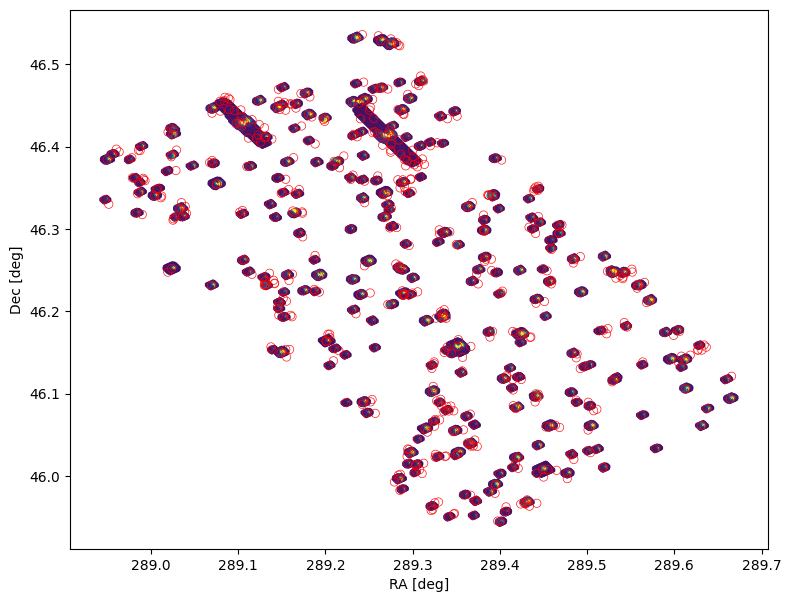

In [65]:
plt.figure(figsize=(9,7))
plt.scatter(mac.ra, mac.dec, c=mac.flux[1000], 
            vmin=0, vmax=5000, s=10, marker="h")
plt.scatter(mac.sources.ra, mac.sources.dec, 
            facecolors="none",
            edgecolors="r",
            linewidths=0.5,
            alpha=0.9,)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
# we'll do a zoom in
# plt.xlim(291, 291.2)
# plt.ylim(36.6, 36.8)
plt.show()

This batch contains two extended mask

### 3.3 Remove background

In the paper we augmented the background pixels using engineering data. 
Kepler mission observed background pixels homogeneously distributed across the CCDs.
We can download a file from the MAST archive

In [ ]:
# download engineering files from the archive using the CCD module and output and the observation date using FITSIO
!curl --globoff --location-trusted -f --progress-bar --create-dirs -C - --output 'data/engineering_bkg/kplr121-2010174085026_bkg.fits.gz' 'https://archive.stsci.edu/missions/kepler/bkg/2010/kplr104-2010174085026_bkg.fits.gz'

In [67]:
bkg_file = "data/engineering_bkg/kplr121-2010174085026_bkg.fits.gz"

mission_bkg_pixels = fitsio.read(bkg_file, columns=["RAWY", "RAWX"], ext=2)
mission_bkg_data = fitsio.read(bkg_file, columns=["CADENCENO", "FLUX"], ext=1)

# match cadences
cadence_mask = np.in1d(mac.tpfs[0].time.jd, mac.time)
cadenceno_mac = mac.tpfs[0].cadenceno[cadence_mask]
mission_mask = np.in1d(mission_bkg_data["CADENCENO"], cadenceno_mac)

keep_pix = (mission_bkg_pixels["RAWY"] > mac.row.min() - 50) & (
    mission_bkg_pixels["RAWY"] < mac.row.max() + 50
)
# get data
data_augment = {
    "row": mission_bkg_pixels["RAWY"][keep_pix],
    "column": mission_bkg_pixels["RAWX"][keep_pix],
    "flux": mission_bkg_data["FLUX"][mission_mask][:, keep_pix],
}

/Users/jorgemarpa/Work/BAERI/ADAP/psfmachine/src/psfmachine/machine.py:387: RuntimeWarning: divide by zero encountered in log10
  temp_mask = (r < source_rad[:, None]) & (


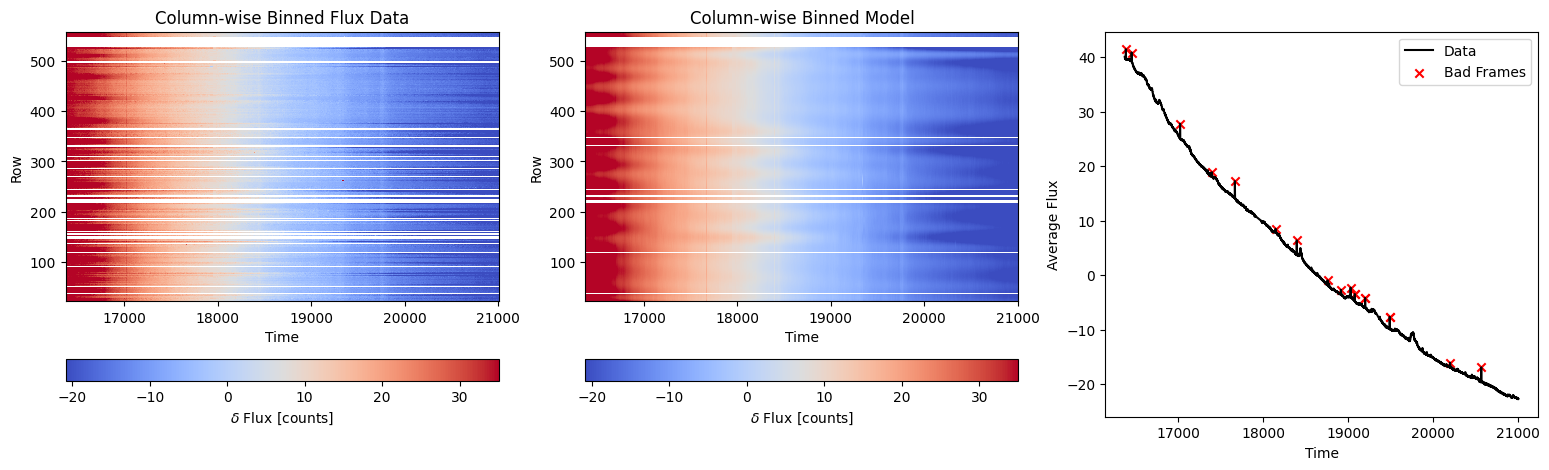

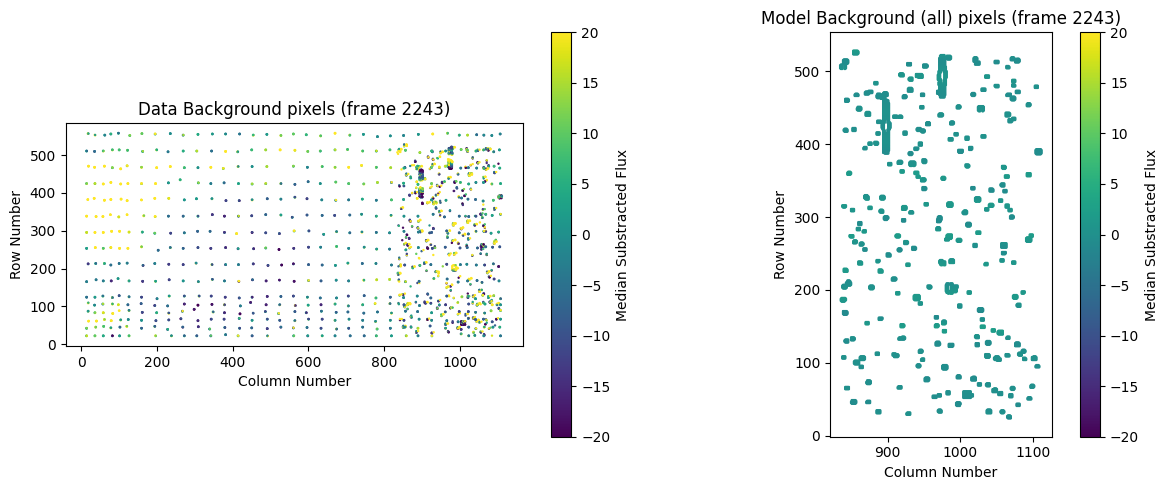

In [68]:
mac.remove_background_model(
        plot=True,
        data_augment=data_augment,
    )
plt.show()

### 3.4 Load PSF model

Now we will load the PSF model that were precomputed from FFI data. `psfmachine` comes loaded with the necessary files and the API automatically identifies the corresponding files.

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/numpy/lib/function_base.py:1235: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/numpy/lib/function_base.py:1263: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


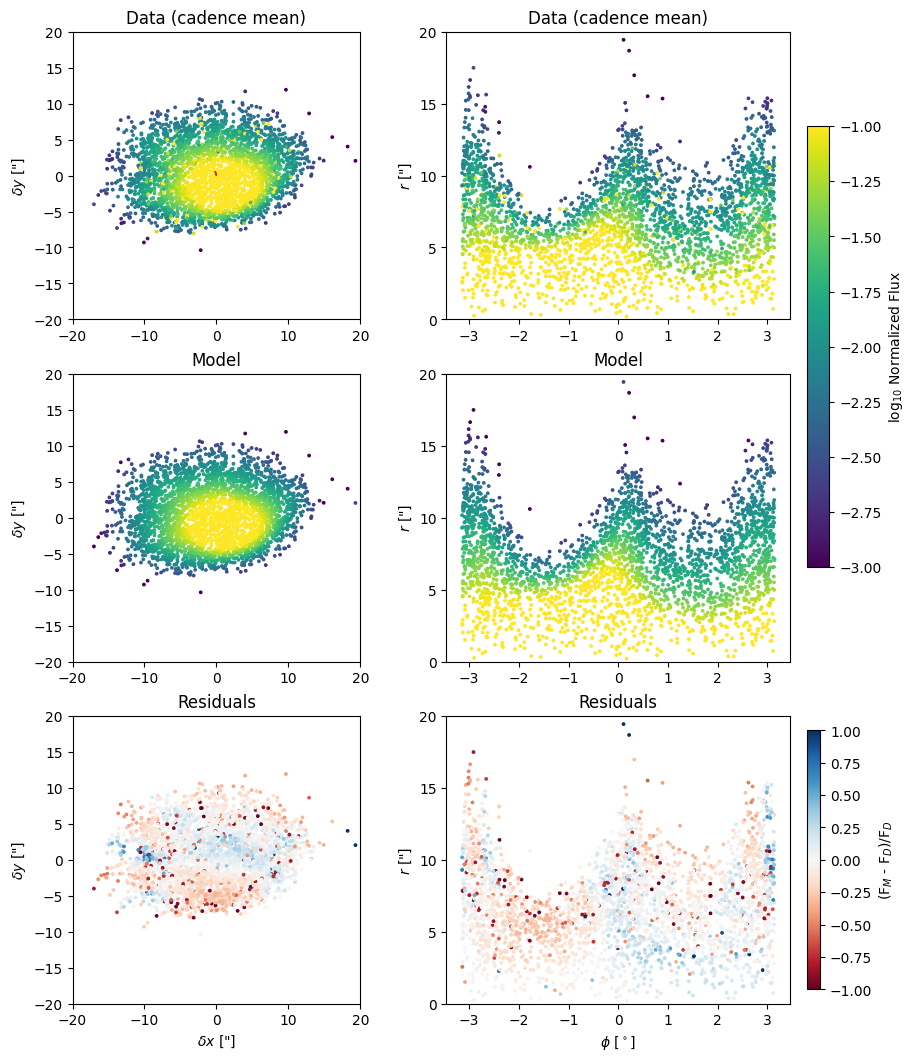

In [69]:
mac.load_shape_model(plot=True)
plt.show()

### 3.5 Fit perturbation model

We first load CBVs from archive and apply a b-spline smoothing function to remove high frequency signal.

In [71]:
ncomp = 4
cbv_spline_dt = 1 

# download cbv from archive
aux = lk.download_kepler_cbvs(
        mission='Kepler',
        quarter=tpfs[0].quarter,
        module=tpfs[0].module,
        output=tpfs[0].output,
    )
cbv_cdn = aux["CADENCENO"]
cbv_vec = np.vstack([aux[f"VECTOR_{i}"] for i in range(1, ncomp + 1)])

# align cadences
mask = np.isin(cbv_cdn, mac.cadenceno)
cbv_cdn = cbv_cdn[mask]
cbv_vec = cbv_vec[:, mask]

# apply b-spline smoothing
cbv_vec_smooth = pm.utils.bspline_smooth(
    cbv_vec,
    x=mac.time,
    do_segments=True,
    n_knots=int((mac.time.max() - mac.time.min()) / cbv_spline_dt),
)
other_vectors = (cbv_vec_smooth - cbv_vec_smooth.mean()) / (cbv_vec_smooth.max() - cbv_vec_smooth.mean())

/var/folders/lz/gmp0cdwx3_v5v7qww7r6sg100000gn/T/ipykernel_85574/4130455755.py:5: LightkurveDeprecationWarning: The download_kepler_cbvs function is deprecated and may be removed in a future version.
        Use load_kepler_cbvs instead.
  aux = lk.download_kepler_cbvs(


We build the the time model including the CBV vectors in the `other_vectors` parameter.
This will build a low resolution (time) perturbation matrix that operates on the mean PSF to correct it at each cadence.

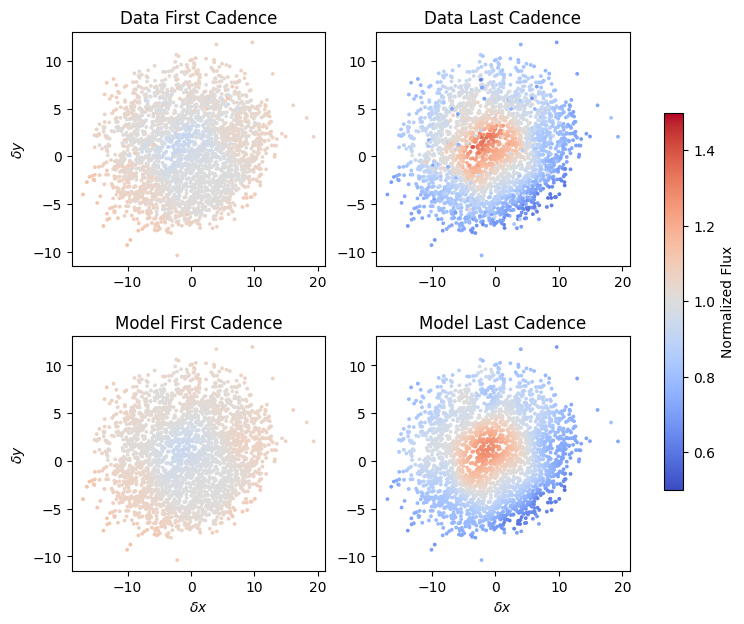

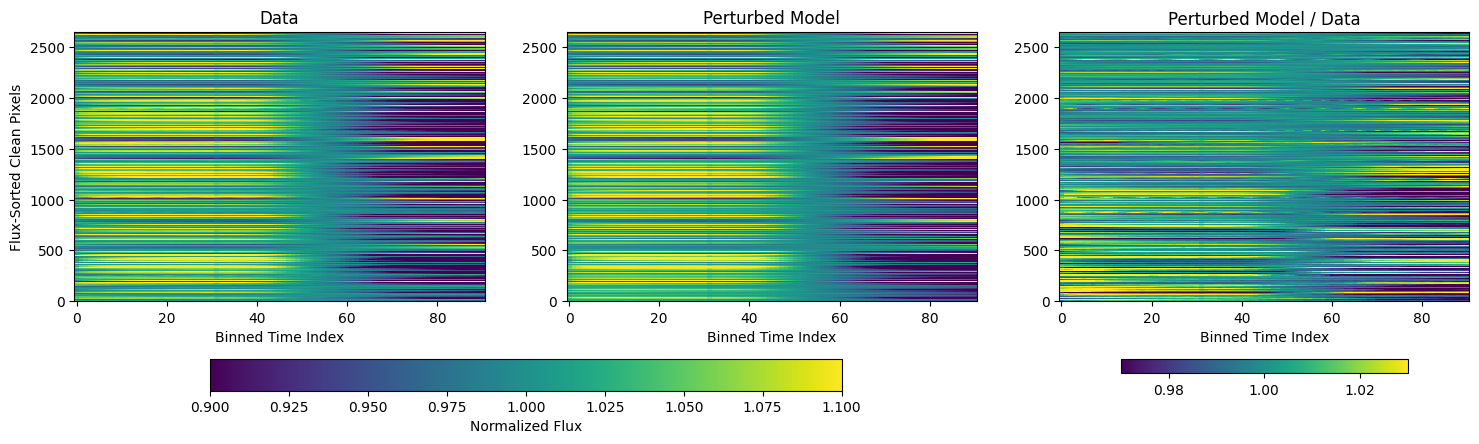

In [76]:
mac.build_time_model(**config["time_model"], other_vectors=other_vectors, plot=True)
plt.show()

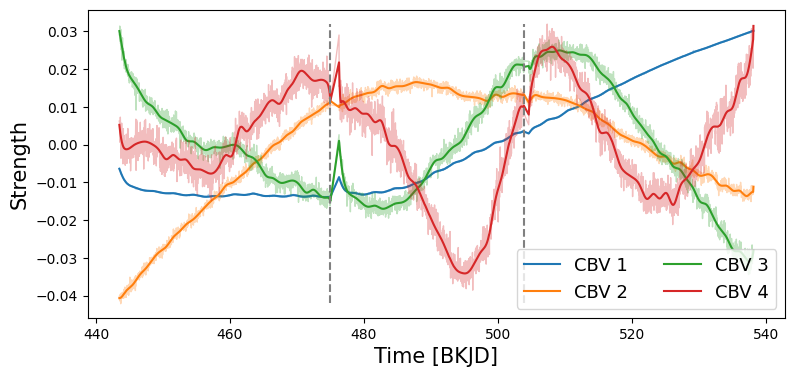

In [77]:
bkjd0 = 2454833.0

plt.figure(figsize=(9,4))
colors = cm.tab10(range(ncomp))
for k in range(ncomp):
    plt.plot(mac.time - bkjd0, cbv_vec[k], 
             c=colors[k], alpha=.3, lw=1)
    plt.plot(mac.time - bkjd0, cbv_vec_smooth[k], 
             c=colors[k], label=f"CBV {k+1}")
plt.vlines(mac.time[mac.P.breaks-1] - bkjd0, -0.042, 0.032, 
           color="gray", linestyle="--", lw=1.5)
plt.legend(loc="lower right", frameon=True, fancybox=True, 
           fontsize=13, ncols=2)
plt.xlabel("Time [BKJD]", fontsize=15)
plt.ylabel("Strength", fontsize=15)

plt.show()

This are the first 4 CBVs (light lines) and the smooth versions (bold lines). The vertical lines show where data discontinuities are due to data downlink or masked cadences.

### 3.6 Fit photometry

Computing the aperture and PSF photometry will create attributes with the vectors as `[n_times, n_sources]`.
There are 3 photometry flavors:
* **aperture** which is computed from an optimized aperture mask `mac.sap_flus``
* **mean_psf** which is from the mean PSF model of the quarter `mac.ws`
* **corrected_psf** which is from the corrected PSF at each cadence `mac.ws_va`

In [78]:
# psf photometry
mac.fit_model(fit_va=True)

# aperture photometry
mac.compute_aperture_photometry(**config["compute_aperture_photometry"])

Optimizing apertures per source:   0%|                                                         | 0/632 [00:00<?, ?it/s]/Users/jorgemarpa/Work/BAERI/ADAP/psfmachine/src/psfmachine/aperture.py:280: RuntimeWarning: divide by zero encountered in divide
  ratio = psf_models.multiply(1 / psf_models.sum(axis=0)).tocsr()
Optimizing apertures per source:   1%|▍                                                | 6/632 [00:00<00:25, 24.95it/s]/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jorgemarpa/Work/BAERI/ADAP/psfmachine/src/psfmachine/aperture.py:252: RuntimeWarning: invalid value encountered in divide
  psf_models.multiply(aperture_mask.astype(float)).sum(axis=1)
/Users/jorgemarpa/Work/BAERI/ADAP/psfmachine/src/psfmachine/aperture.py:286: RuntimeWarning: invalid value encountered in double_scalars
  return ratio[idx].toarray()[0][aperture_mas

In [83]:
mac.ws_va.shape

(4487, 632)

### 3.8 Compute centroids

We compute centroids using the `"scene"` method that corrects Gaia coordinates with the scene movement in each cadence.
This creates an attribute with the centroid time series and its mean values.

In [79]:
mac.get_source_centroids(**config["get_source_centroids"])